***
*Course:* [Math 535](http://www.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Author:* [Sebastien Roch](http://www.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
***

# <span style="background-color:dodgerblue; color:white; padding:2px 6px">APPLICATIONS</span> 
# Logistic regression


*Updated:* April 16, 2020 

In [1]:
# Julia version: 1.3.1
using CSV, DataFrames, Plots, GLM, LinearAlgebra, Statistics

## 1 Background

In this notebook, we illustrate the use of gradient descent on binary classification by logistic regression. 

**Classification.** Quoting [Wikipedia](https://en.wikipedia.org/wiki/Statistical_classification), recall that classification is the following machine learning task:

> In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known. Examples are assigning a given email to the "spam" or "non-spam" class, and assigning a diagnosis to a given patient based on observed characteristics of the patient (sex, blood pressure, presence or absence of certain symptoms, etc.). Classification is an example of pattern recognition. In the terminology of machine learning, classification is considered an instance of supervised learning, i.e., learning where a training set of correctly identified observations is available. 

The input data is of the form $\{(\boldsymbol{\alpha}_i, b_i) : i=1,\ldots, n\}$ where $\boldsymbol{\alpha}_i \in \mathbb{R}^d$ are the features and $b_i \in \{0,1\}$ is the label. As before we use a matrix representation: $A \in \mathbb{R}^{n \times d}$ has rows $\boldsymbol{\alpha}_j^T$, $j = 1,\ldots, n$ and $\mathbf{b} = (b_1, \ldots, b_n)^T \in \{0,1\}^n$. 

**Logistic model.** We summarize the logistic regression approach. Our goal is to find a function of the features that approximates the probability of the label $1$. For this purpose, we model the [log-odds](https://en.wikipedia.org/wiki/Logit) (or logit function) of the probability of label $1$ as a linear function of the features

$$
\log \frac{p(\boldsymbol{\alpha}; \mathbf{x})}{1-p(\boldsymbol{\alpha}; \mathbf{x})}
= \boldsymbol{\alpha}^T \mathbf{x}
$$

where $\mathbf{x} \in \mathbb{R}^d$. Inverting this expression gives

$$
p(\boldsymbol{\alpha}; \mathbf{x})
= \sigma(\boldsymbol{\alpha}^T \mathbf{x})
$$

where the [sigmoid](https://en.wikipedia.org/wiki/Logistic_function) function is

$$
\sigma(t)
= \frac{1}{1 + e^{-t}}
$$

for $t \in \mathbb{R}$.

We seek to maximize the likelihood of the data assuming the labels are independent given the features, which is given by

$$
\mathcal{L}(\mathbf{x}; A, \mathbf{b})
= \prod_{i=1}^n p(\boldsymbol{\alpha}_i; \mathbf{x})^{b_i} 
(1- p(\boldsymbol{\alpha}_i; \mathbf{x}))^{1-b_i}
$$

Taking a logarithm, multiplying by $-1/n$ and substituting the sigmoid function, we want to minimize the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)

$$
\ell(\mathbf{x}; A, \mathbf{b})
= - \frac{1}{n} \sum_{i=1}^n b_i \log(\sigma(\boldsymbol{\alpha}^T \mathbf{x}))
- \frac{1}{n} \sum_{i=1}^n (1-b_i) \log(1- \sigma(\boldsymbol{\alpha}^T \mathbf{x})).
$$

That is, we solve

$$
\min_{\mathbf{x} \in \mathbb{R}^d} \ell(\mathbf{x}; A, \mathbf{b}).
$$

**Gradient descent.** To use gradient descent, we need the gradient of $\ell$. We use the Chain Rule and first compute the derivative of $\sigma$ which is

$$
\sigma'(t)
= \frac{e^{-t}}{(1 + e^{-t})^2}
= \frac{1}{1 + e^{-t}}\left(1 - \frac{1}{1 + e^{-t}}\right)
= \sigma(t) (1 - \sigma(t)).
$$

The latter expression is known as the [logistic differential equation](https://en.wikipedia.org/wiki/Logistic_function#Logistic_differential_equation). It arises in a variety of applications, including the modeling of [population dynamics](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d). Here it will be a convenient way to compute the gradient. Indeed observe that by the Chain Rule

$$
\nabla_{\mathbf{x}}\,\sigma(\boldsymbol{\alpha}^T \mathbf{x})
= \sigma(\boldsymbol{\alpha}^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}^T \mathbf{x}))\, \boldsymbol{\alpha}
$$

where we use a subscript $\mathbf{x}$ to make it clear that the gradient is with respect to $\mathbf{x}$.

By another application of the Chain Rule

$$
\begin{align*}
\nabla_{\mathbf{x}}\,\ell(\mathbf{x}; A, \mathbf{b})
&= - \frac{1}{n} \sum_{i=1}^n \frac{b_i}{\sigma(\boldsymbol{\alpha}_i^T \mathbf{x})} \nabla_{\mathbf{x}}\,\sigma(\boldsymbol{\alpha}_i^T \mathbf{x})
+ \frac{1}{n} \sum_{i=1}^n \frac{1-b_i}{1- \sigma(\boldsymbol{\alpha}_i^T \mathbf{x})} \nabla_{\mathbf{x}}\,\sigma(\boldsymbol{\alpha}_i^T \mathbf{x})\\
&= - \frac{1}{n} \sum_{i=1}^n \left(
\frac{b_i}{\sigma(\boldsymbol{\alpha}_i^T \mathbf{x})} - \frac{1-b_i}{1- \sigma(\boldsymbol{\alpha}_i^T \mathbf{x})} 
\right) \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x})) \,\boldsymbol{\alpha}_i\\
&= - \frac{1}{n} \sum_{i=1}^n (
b_i - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}) 
) \,\boldsymbol{\alpha}_i.
\end{align*}
$$

To compute the Hessian, we note that

$$
\nabla_{\mathbf{x}} (\sigma(\boldsymbol{\alpha}^T \mathbf{x})\, \alpha_j) 
=  \sigma(\boldsymbol{\alpha}^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}^T \mathbf{x}))\, \boldsymbol{\alpha}\,\alpha_j
$$

so that

$$
\nabla_{\mathbf{x}} (\sigma(\boldsymbol{\alpha}^T \mathbf{x})\,\boldsymbol{\alpha}) 
=  \sigma(\boldsymbol{\alpha}^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}^T \mathbf{x}))\, \boldsymbol{\alpha} \boldsymbol{\alpha}^T.
$$

Thus

$$
\nabla^2_{\mathbf{x}} \,\ell(\mathbf{x}; A, \mathbf{b})
= \frac{1}{n} \sum_{i=1}^n \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}))\, \boldsymbol{\alpha}_i \boldsymbol{\alpha}_i^T
$$

where $\nabla^2_{\mathbf{x}}$ indicates the Hessian with respect to the $\mathbf{x}$ variables.

***

**Lemma (Convexity of logistic regression):** The function $\ell(\mathbf{x}; A, \mathbf{b})$ is convex as a function of $\mathbf{x} \in \mathbb{R}^d$.

***

*Proof:* Indeed, the Hessian is PSD: for any $\mathbf{z} \in \mathbb{R}^d$

$$
\begin{align*}
\mathbf{z}^T \,\nabla^2_{\mathbf{x}} \,\ell(\mathbf{x}; A, \mathbf{b}) \,\mathbf{z}
&= \frac{1}{n} \sum_{i=1}^n \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}))\, \mathbf{z}^T \boldsymbol{\alpha}_i \boldsymbol{\alpha}_i^T \mathbf{z}\\
&= \frac{1}{n} \sum_{i=1}^n \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}) (1 - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}))\, (\mathbf{z}^T \boldsymbol{\alpha}_i)^2\\ 
&\geq 0 
\end{align*}
$$

since $\sigma(t) \in [0,1]$ for all $t$. $\square$

Convexity is one reason for working with the cross-entropy loss ([rather than the mean squared error](https://math.stackexchange.com/questions/1582452/logistic-regression-prove-that-the-cost-function-is-convex) for instance).

**Update formula.** For step size $\beta$, one step of gradient descent is therefore

$$
\mathbf{x}^{k+1}
= \mathbf{x}^{k} +\beta \frac{1}{n} \sum_{i=1}^n (
b_i - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}^k) 
) \,\boldsymbol{\alpha}_i.
$$

In [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD), a variant of gradient descent, we pick a sample $I$ uniformly at random in $\{1,\ldots,n\}$ and update as follows

$$
\mathbf{x}^{k+1}
= \mathbf{x}^{k} +\beta \, (
b_I - \sigma(\boldsymbol{\alpha}_I^T \mathbf{x}^k) 
) \, \boldsymbol{\alpha}_I.
$$

For the mini-batch version of SGD, we pick a random sub-sample $\mathcal{B} \subseteq \{1,\ldots,n\}$ of size $B$

$$
\mathbf{x}^{k+1}
= \mathbf{x}^{k} +\beta \frac{1}{B} \sum_{i\in \mathcal{B}} (
b_i - \sigma(\boldsymbol{\alpha}_i^T \mathbf{x}^k) 
) \,\boldsymbol{\alpha}_i.
$$

The key observation about the two stochastic updates above is that, in expectation, they perform a step of gradient descent. That turns out to be enough and it has computational advantages. Many variants exist and we will encounter some of them in the next notebook.

## 2 Lebron James 2017 NBA Playoffs dataset

We start with a simple dataset from UC Berkeley's [DS100](http://www.ds100.org) course. The file `lebron.csv` is available [here](https://github.com/DS-100/textbook/tree/master/content/ch/17). Quoting the course's textbook [[DS100](https://www.textbook.ds100.org/intro.html), Section 17.1]:

> In basketball, players score by shooting a ball through a hoop. One such player, LeBron James, is widely considered one of the best basketball players ever for his incredible ability to score. LeBron plays in the National Basketball Association (NBA), the United States's premier basketball league. We've collected a dataset of all of LeBron's attempts in the 2017 NBA Playoff Games using the NBA statistics website (https://stats.nba.com/).

We first load the data and look at its summary.

In [2]:
df = CSV.read("./lebron.csv")
first(df,5)

,game_date,minute,opponent,action_type,shot_type,shot_distance
,Int64,Int64,String,String,String,Int64
1,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0
2,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0
3,20170415,14,IND,Layup Shot,2PT Field Goal,0
4,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0
5,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0


In [3]:
nrow(df)

384

In [4]:
describe(df)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,game_date,2.01705e7,20170415,2.01705e7,20170612
2,minute,24.4063,1,25.0,48
3,opponent,,BOS,,TOR
4,action_type,,Alley Oop Dunk Shot,,Turnaround Jump Shot
5,shot_type,,2PT Field Goal,,3PT Field Goal
6,shot_distance,10.6953,0,6.5,31
7,shot_made,0.565104,0,1.0,1


The two columns we will be interested in are `shot_distance` (LeBron's distance from the basket when the shot was attempted (ft)) and `shot_made` (0 if the shot missed, 1 if the shot went in). As the summary table above indicates, the average distance was `10.6953` and the frequency of shots made was `0.565104`. We extract those two columns and display them on a scatter plot.

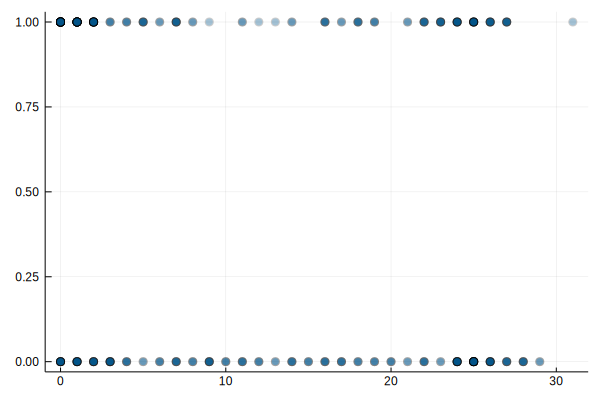

In [5]:
feature = df[:,:shot_distance]
label = df[:,:shot_made]
scatter(feature, label; legend=false, alpha=0.2)

As you can see, this kind of data is hard to vizualize because of the superposition of points with the same $x$ and $y$-values. One trick is to jiggle the $y$'s a little bit by adding Gaussian noise. We do this next and plot again.

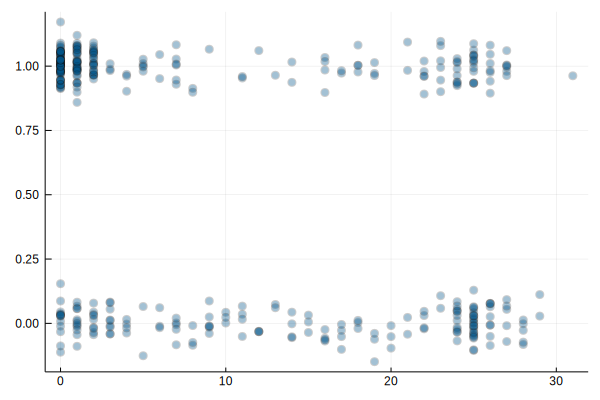

In [6]:
label_jitter = label .+ 0.05*randn(length(label))
scatter(feature, label_jitter; legend=false, alpha=0.2)

To run gradient descent (GD), we first implement a function computing an update. It takes as input a function `grad_fn` computing the gradient itself.

In [7]:
function desc_update(grad_fn, A, b, curr_x, β)
    gradient = grad_fn(curr_x, A, b)
    return curr_x .- β*gradient
end

desc_update (generic function with 1 method)

We are ready to implement GD. Our function takes as input a function `loss_fn` computing the objective, a function `grad_fn` computing the gradient and the dataset `A` and `b`. Optional parameters are an initial guess `init_x`, the step size, and the number of iterations. (To get $\beta$, try `\beta<tab>` where `<tab>` is the tab key.)

In [8]:
function mmids_gd(loss_fn, grad_fn, A, b; 
        init_x=zeros(size(A,2)), β=1e-3, niters=1e6)
    
    # current x and loss
    curr_x, curr_l = init_x, loss_fn(init_x, A, b)
    
    # until the maximum number of iterations
    for iter = 1:niters
        curr_x = desc_update(grad_fn, A, b, curr_x, β) # gradient step
        
        # print progress every 100000 iterations
        if iter % 100000 == 0 
            @show iter, loss_fn(curr_x, A, b)
        end
    end
    
    return curr_x
end

mmids_gd (generic function with 1 method)

We apply GD to logistic regression. We first construct the data matrices $A$ and $\mathbf{b}$. To allow an affine function of the features, we add a column of $1$'s as we have done before.  

In [9]:
A = [ones(length(label)) feature]
b = label;

To implement `loss_fn` and `grad_fn`, we define the sigmoid first.

In [10]:
sigmoid = z -> 1/(1+exp(-z))
pred_fn = (x, A) -> sigmoid.(A*x)
loss_fn = (x, A, b) -> mean(-b.*log.(pred_fn(x, A)) 
    .-(1 .- b).*log.(1 .- pred_fn(x, A)))

#8 (generic function with 1 method)

In [11]:
grad_fn = (x, A, b) -> -A'*(b.-pred_fn(x, A))/length(b)

#10 (generic function with 1 method)

We run GD starting from $(0,0)$ with a step size of $0.01$.

In [12]:
init_x = zeros(size(A,2))
@time best_x = mmids_gd(loss_fn, grad_fn, A, b;
    β=0.01, niters=10000)

  0.956010 seconds (2.24 M allocations: 263.722 MiB, 7.61% gc time)


2-element Array{Float64,1}:
  0.9095669233878183  
 -0.058907173767627455

Finally we plot the results.

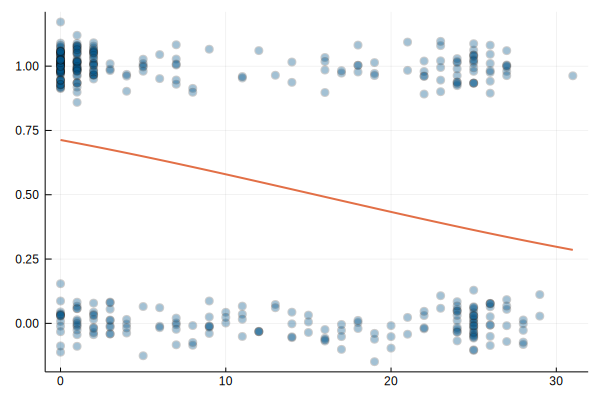

In [13]:
grid = LinRange(minimum(feature), maximum(feature), 100)
feature_grid = [ones(length(grid)) grid]
predict_grid = sigmoid.(feature_grid*best_x)
scatter(feature, label_jitter, legend=false, alpha=0.2)
plot!(grid,predict_grid;lw=2)

The package [GLM.jl](https://github.com/JuliaStats/GLM.jl). GLM stands for [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model), a broad generalization of linear regression based on the [exponential family](https://en.wikipedia.org/wiki/Exponential_family) that includes logistic regression. More details on the syntax is [here](https://juliastats.org/GLM.jl/stable/manual/#Fitting-GLM-models-1).

In [14]:
model = glm(@formula(shot_made ~ shot_distance), df, Bernoulli(), LogitLink());

In [15]:
coeftable(model)

─────────────────────────────────────────────────────────────────────────────────
                 Estimate  Std. Error   z value  Pr(>|z|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)     0.90959     0.157718    5.7672      <1e-8   0.600469    1.21871  
shot_distance  -0.0589083   0.0102974  -5.72068     <1e-7  -0.0790908  -0.0387257
─────────────────────────────────────────────────────────────────────────────────

We do get the same answer. 

## 3 South African Heart Disease dataset

We analyze a dataset from [[ESL](https://web.stanford.edu/~hastie/ElemStatLearn/)], which can be downloaded [here](https://web.stanford.edu/~hastie/ElemStatLearn/data.html). Quoting [[ESL](https://web.stanford.edu/~hastie/ElemStatLearn/), Section 4.4.2] 

> The data [...] are a subset of the Coronary Risk-Factor Study (CORIS) baseline survey, carried out in three rural areas of the Western Cape, South Africa (Rousseauw et al., 1983). The aim of the study was to establish the intensity of ischemic heart disease risk factors in that high-incidence region. The data represent white males between 15 and 64, and the response variable is the presence or absence of myocardial infarction (MI) at the time of the survey (the overall prevalence of MI was 5.1% in this region). There are 160 cases in our data set, and a sample of 302 controls. These data are described in more detail in Hastie and Tibshirani (1987).

We load the data, which we slightly reformatted and look at a summary. 

In [16]:
df = CSV.read("./SAHeart.csv")
first(df,5)

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,160.0,12.0,5.73,23.11,49.0,25.3,97.2,52.0,1.0
2,144.0,0.01,4.41,28.61,55.0,28.87,2.06,63.0,1.0
3,118.0,0.08,3.48,32.28,52.0,29.14,3.81,46.0,0.0
4,170.0,7.5,6.41,38.03,51.0,31.99,24.26,58.0,1.0
5,134.0,13.6,3.5,27.78,60.0,25.99,57.34,49.0,1.0


In [17]:
nrow(df)

462

In [18]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,sbp,138.327,101.0,134.0,218.0,,,Float64
2,tobacco,3.63565,0.0,2.0,31.2,,,Float64
3,ldl,4.74032,0.98,4.34,15.33,,,Float64
4,adiposity,25.4067,6.74,26.115,42.49,,,Float64
5,typea,53.1039,13.0,53.0,78.0,,,Float64
6,obesity,26.0441,14.7,25.805,46.58,,,Float64
7,alcohol,17.0444,0.0,7.51,147.19,,,Float64
8,age,42.816,15.0,45.0,64.0,,,Float64
9,chd,0.34632,0.0,0.0,1.0,,,Float64


Our goal to predict `chd`, which stands for coronary heart disease, based on the other variables (which are briefly described [here](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.info.txt)). We use logistic regression again. 

We first construct the data matrices. We only use three of the predictors, as the convergence is quite slow. Try it for yourself! 

In [19]:
feature = Matrix(df[:,[2,3,8]])
label = Vector(df[:,end])
A = [ones(length(label)) feature]
b = label;

We re-use the functions `loss_fn` and `grad_fn`, which were written for general logistic regression problems.

In [20]:
init_x = zeros(size(A,2))
@time best_x = mmids_gd(loss_fn, grad_fn, A, b)

(iter, loss_fn(curr_x, A, b)) = (100000.0, 0.5512760808560835)
(iter, loss_fn(curr_x, A, b)) = (200000.0, 0.5450448548033354)
(iter, loss_fn(curr_x, A, b)) = (300000.0, 0.5443062770469598)
(iter, loss_fn(curr_x, A, b)) = (400000.0, 0.5442013427515154)
(iter, loss_fn(curr_x, A, b)) = (500000.0, 0.5441854702807585)
(iter, loss_fn(curr_x, A, b)) = (600000.0, 0.5441830121092444)
(iter, loss_fn(curr_x, A, b)) = (700000.0, 0.544182627907757)
(iter, loss_fn(curr_x, A, b)) = (800000.0, 0.5441825676419146)
(iter, loss_fn(curr_x, A, b)) = (900000.0, 0.5441825581751376)
(iter, loss_fn(curr_x, A, b)) = (1.0e6, 0.5441825566872227)
 19.030730 seconds (18.91 M allocations: 25.273 GiB, 26.12% gc time)


4-element Array{Float64,1}:
 -4.047552362131421  
  0.07638141278110212
  0.18726607554052066
  0.04850750902902933

To get a sense of how accurate the result is, we compare our predictions to the true labels. By prediction, let us say that we mean that we predict label $1$ whenever $\sigma(\mathbf{a}^T \mathbf{x}) > 1/2$. We try this on the training set. (A better approach would be to split the data into training and testing sets, but we will not do this here.)

In [21]:
function logis_acc(x, A, b)
    return sum((pred_fn(x, A) .> 0.5) .== b)/length(b)
end

logis_acc (generic function with 1 method)

In [22]:
logis_acc(best_x, A, b)

0.7251082251082251

Here is what is obtained with the [GLM.jl](https://github.com/JuliaStats/GLM.jl) package, which uses the [iteratively reweighted least squares (IRLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) algorithm.

In [23]:
@time model = glm(@formula(chd ~ tobacco+ldl+age), df, 
    Bernoulli(), LogitLink());

  1.052423 seconds (1.75 M allocations: 90.815 MiB, 3.62% gc time)


In [24]:
coeftable(model)

───────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error   z value  Pr(>|z|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  -4.0478     0.483068    -8.37935    <1e-16  -4.99459    -3.101    
tobacco       0.0763804  0.025539     2.99074    0.0028   0.0263249   0.126436 
ldl           0.187278   0.0541641    3.45761    0.0005   0.0811186   0.293438 
age           0.0485112  0.00945247   5.13212    <1e-6    0.0299847   0.0670377
───────────────────────────────────────────────────────────────────────────────

While the coefficients obtained are quite different from our GD implementation, the prediction accuracy is not much better.

In [25]:
logis_acc(coef(model), A, b)

0.7251082251082251

We also try mini-batch stochastic gradient descent (SGD). The only modification needed to the code is to pick a random mini-batch.

In [26]:
function mmids_sgd(loss_fn, grad_fn, A, b; 
        init_x=zeros(size(A,2)), β=1e-3, niters=1e6, batch=40)
    
    # current x and loss
    curr_x, curr_l = init_x, loss_fn(init_x, A, b)
    
    # until the maximum number of iterations
    nsamples = length(b) # number of samples
    for iter = 1:niters
        I = rand(1:nsamples, batch)
        curr_x = desc_update(grad_fn, A[I,:], b[I], curr_x, β) # gradient step
        
        # print progress every 100000 iterations
        if iter % 100000 == 0 
            @show iter, loss_fn(curr_x, A, b)
        end
    end
    
    return curr_x
end

mmids_sgd (generic function with 1 method)

In [27]:
init_x = zeros(size(A,2))
@time best_x = mmids_sgd(loss_fn, grad_fn, A, b)

(iter, loss_fn(curr_x, A, b)) = (100000.0, 0.5519142020443963)
(iter, loss_fn(curr_x, A, b)) = (200000.0, 0.5469213794544747)
(iter, loss_fn(curr_x, A, b)) = (300000.0, 0.5530500114386208)
(iter, loss_fn(curr_x, A, b)) = (400000.0, 0.545755871926802)
(iter, loss_fn(curr_x, A, b)) = (500000.0, 0.5455974091362046)
(iter, loss_fn(curr_x, A, b)) = (600000.0, 0.5442192800049873)
(iter, loss_fn(curr_x, A, b)) = (700000.0, 0.5461141000037584)
(iter, loss_fn(curr_x, A, b)) = (800000.0, 0.54431882725751)
(iter, loss_fn(curr_x, A, b)) = (900000.0, 0.5447380724692122)
(iter, loss_fn(curr_x, A, b)) = (1.0e6, 0.5459362176194176)
  5.201525 seconds (24.22 M allocations: 5.092 GiB, 18.84% gc time)


4-element Array{Float64,1}:
 -4.064191393923518  
  0.0726330480873891 
  0.18792592374528583
  0.05192171175942792

In [28]:
logis_acc(best_x, A, b)

0.7186147186147186